In [3]:

# Commented out IPython magic to ensure Python compatibility.
# %pip install yfinance arch statsmodels
# %pip install yfinance arch statsmodels seaborn
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import jarque_bera
import seaborn as sns
from scipy.stats import norm
from scipy.stats import kstest, anderson
from statsmodels.distributions.empirical_distribution import ECDF
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from tabulate import tabulate
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import mplfinance as mpf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import random
from tqdm import tqdm
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


In [4]:
#Dati dal 2015 ad oggi
data = pd.read_csv("/home/luca/Mercati/dati_storici_SP500TM5⁄10years.csv", sep=',') 
numero_righe = len(data)
print(numero_righe)
display(data.head())

#ogni giorno ha 78 intervalli, dobbiamo tirargli fuori Lagged 21-day volatility e 60 day volatility e aggiungerlo a un nuovo padas

#obiettivo stimare volatilita gionaliera avendo osservazionia  5 minuti 


195336


,Data,Open,High,Low,Close,Volume
0,20150707 15:30:00,206.93,206.99,206.45,206.45,9761
1,20150707 15:35:00,206.46,206.49,206.28,206.40,4683
2,20150707 15:40:00,206.39,206.39,206.13,206.20,3860
3,20150707 15:45:00,206.19,206.36,206.06,206.30,4742
4,20150707 15:50:00,206.30,206.43,206.12,206.34,3779


In [5]:
# 1. Scarica la serie dei prezzi S&P 500 da Yahoo Finance
ticker      = '^GSPC'
start_date  = '2015-01-01'
end_date    = '2025-01-01'
data2     = yf.download(ticker, start=start_date, end=end_date)

display(data2.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,


## Stima della Volatilità Giornaliera con Dati a 5 Minuti

Sia r_{t,i} il rendimento logaritmico calcolato ogni 5 minuti durante la giornata di trading \( t \), definito come:

$$
r_{t,i} = \log\left( \frac{P_{t,i}}{P_{t,i-1}} \right), \quad i = 1, \dots, n
$$


La volatilità realizzata giornaliera viene stimata come la radice quadrata della somma dei quadrati dei rendimenti intraday:

$$
\text{RV}_t = \sqrt{ \sum_{i=1}^{n} r_{t,i}^2 }
$$

Questa misura fornisce una stima più robusta e informativa della volatilità giornaliera rispetto alla semplice varianza basata sul rendimento giornaliero totale:

$$
\sigma_t^2 \approx r_t^2 = \left( \log\left( \frac{P_t}{P_{t-1}} \right) \right)^2
$$

dove \( P_t \) è il prezzo di chiusura del giorno \( t \).


L’utilizzo dei dati a 5 minuti consente di cogliere la dinamica intraday del prezzo, riducendo l’effetto di outlier e fornendo una stima della varianza più aderente alla realtà del mercato.



In [6]:
# 2. Calcola i rendimenti semplici e logaritmici
data['Simple_Returns'] = data['Close'].pct_change()  #Pt-Pt-1/Pt-1
data['close_log_ret_perc'] = np.log(data['Close'] / data['Close'].shift(1)) *100

#print(data['Log_Returns'])
print(data)

                      Data    Open    High     Low   Close  Volume  \
0       20150707  15:30:00  206.93  206.99  206.45  206.45    9761   
1       20150707  15:35:00  206.46  206.49  206.28  206.40    4683   
2       20150707  15:40:00  206.39  206.39  206.13  206.20    3860   
3       20150707  15:45:00  206.19  206.36  206.06  206.30    4742   
4       20150707  15:50:00  206.30  206.43  206.12  206.34    3779   
...                    ...     ...     ...     ...     ...     ...   
195331  20250703  18:35:00  625.92  625.98  625.85  625.96    1645   
195332  20250703  18:40:00  625.96  626.27  625.94  626.09    1901   
195333  20250703  18:45:00  626.10  626.10  625.66  625.68    2706   
195334  20250703  18:50:00  625.67  625.88  624.88  625.38    4448   
195335  20250703  18:55:00  625.38  625.75  625.23  625.34    6083   

        Simple_Returns  close_log_ret_perc  
0                  NaN                 NaN  
1            -0.000242           -0.024222  
2            -0.000969  

In [7]:
# Rimuovi i NaN introdotti dal primo calcolo
returns_simple = data['Simple_Returns'].dropna()
returns_log    = data['close_log_ret_perc'].dropna()



# Calcoliamo i ritorni giornalieri 

In [8]:


# Converte la colonna Data direttamente in datetime
data["datetime"] = pd.to_datetime(data["Data"], format="%Y%m%d %H:%M:%S", errors="coerce")

# Rimuove righe con datetime non validi
data = data[~data["datetime"].isna()]

# Imposta l'indice
data = data.set_index("datetime").sort_index()


filtered = data.between_time("09:30", "16:00")


daily_volatility = filtered.groupby(filtered.index.date)["close_log_ret_perc"].std()
daily_return = filtered.groupby(filtered.index.date)["close_log_ret_perc"].sum()


daily_stats = pd.DataFrame({
    "log_return": daily_return,
    "volatility": daily_volatility
})

print(daily_stats.head())


            log_return  volatility
2015-07-07   -0.339641    0.087030
2015-07-08   -1.175204    0.219569
2015-07-09    1.108799    0.536777
2015-07-10    1.068023    0.451368
2015-07-13    0.863853    0.300914


# C'è stagionalità tra i dati intaday?

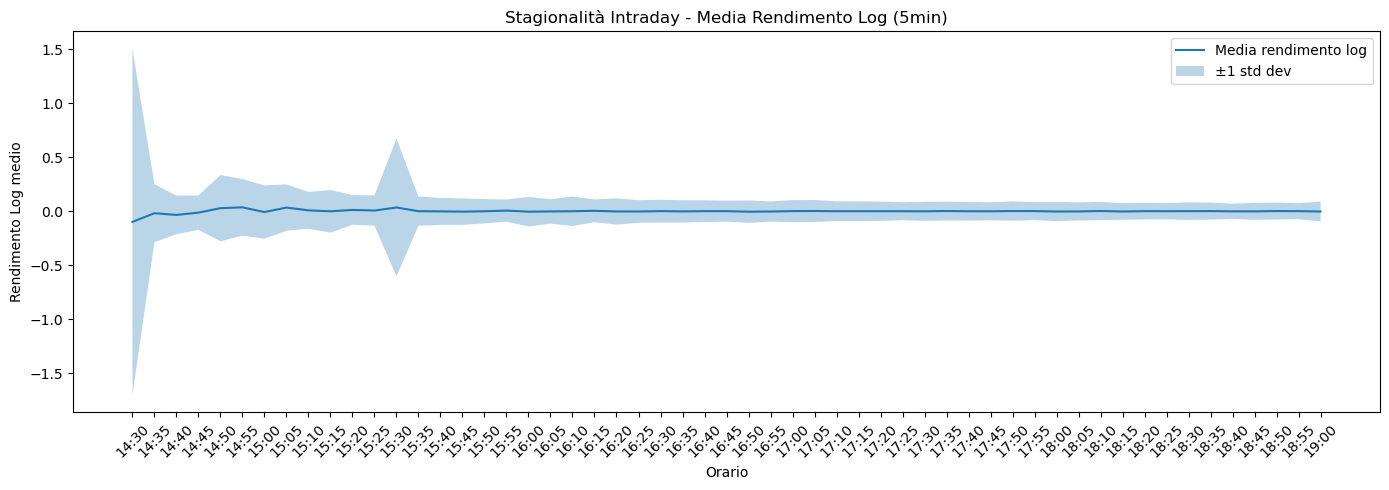

In [8]:
# Esegui solo sui giorni in cui il mercato è aperto
data_intraday = data.between_time("09:30", "19:00")

# Calcola la media per ogni orario (ad es. 09:35, 09:40, ..., 15:55)
mean_by_time = data_intraday.groupby(data_intraday.index.time)['close_log_ret_perc'].mean()
std_by_time = data_intraday.groupby(data_intraday.index.time)['close_log_ret_perc'].std()

# Converte gli orari in stringhe tipo 'HH:MM'
x_labels = [t.strftime("%H:%M") for t in mean_by_time.index]

plt.figure(figsize=(14, 5))
plt.plot(x_labels, mean_by_time.values, label='Media rendimento log')
plt.fill_between(x_labels,
                 mean_by_time.values - std_by_time.values,
                 mean_by_time.values + std_by_time.values,
                 alpha=0.3, label='±1 std dev')
plt.xticks(rotation=45)
plt.title('Stagionalità Intraday - Media Rendimento Log (5min)')
plt.xlabel('Orario')
plt.ylabel('Rendimento Log medio')
plt.legend()
plt.tight_layout()
plt.show()



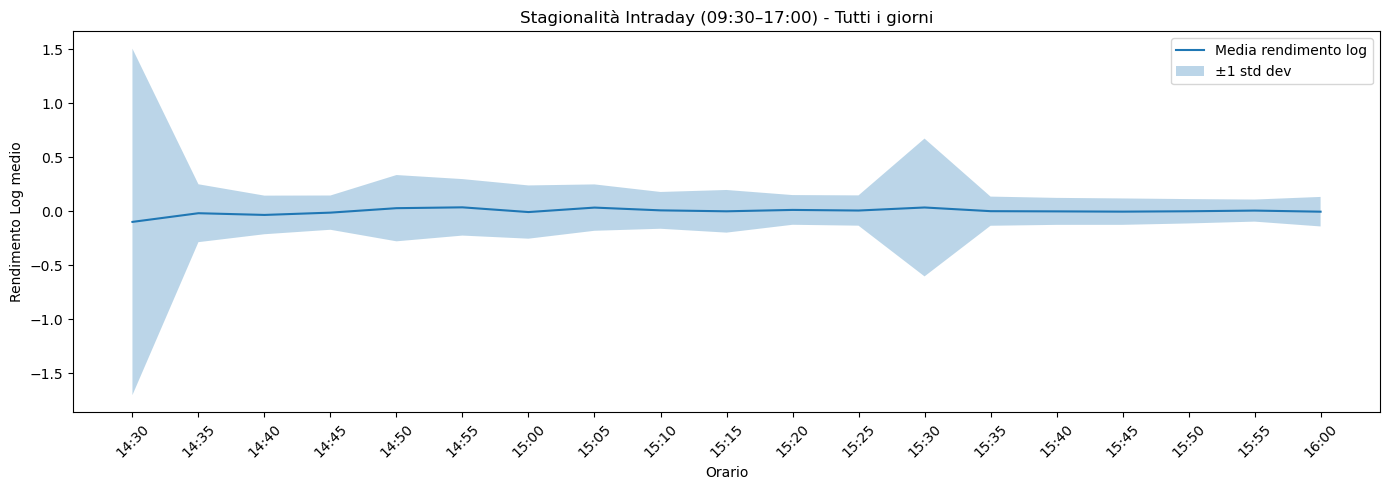

In [11]:


# Raggruppa per orario intraday (usando .time)
mean_by_time = filtered.groupby(filtered.index.time)["close_log_ret_perc"].mean()
std_by_time = filtered.groupby(filtered.index.time)["close_log_ret_perc"].std()

# 🔁 Converte l'indice (oggetti datetime.time) in stringhe per il plotting
time_labels = [t.strftime('%H:%M') for t in mean_by_time.index]

plt.figure(figsize=(14, 5))
plt.plot(time_labels, mean_by_time.values, label='Media rendimento log')
plt.fill_between(time_labels,
                 mean_by_time - std_by_time,
                 mean_by_time + std_by_time,
                 alpha=0.3, label='±1 std dev')

plt.title("Stagionalità Intraday (09:30–17:00) - Tutti i giorni")
plt.xlabel("Orario")
plt.ylabel("Rendimento Log medio")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


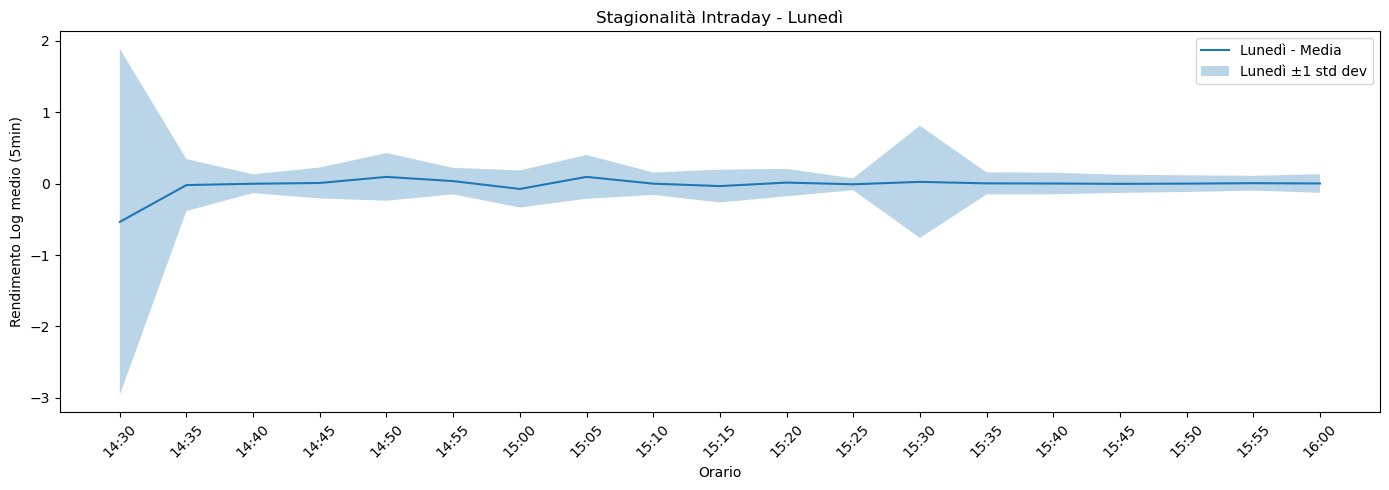

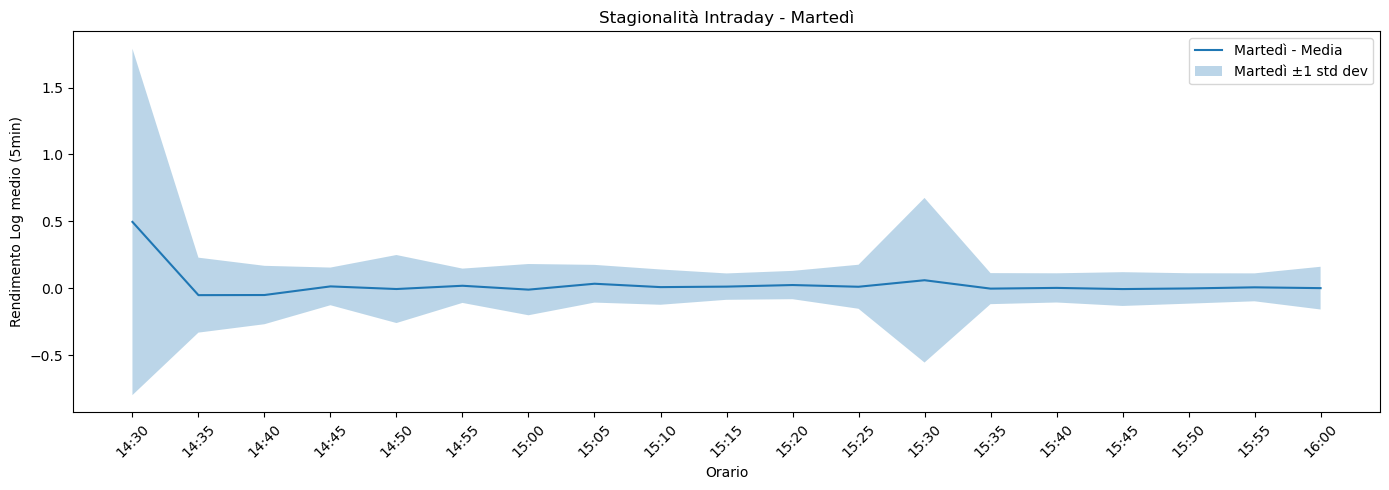

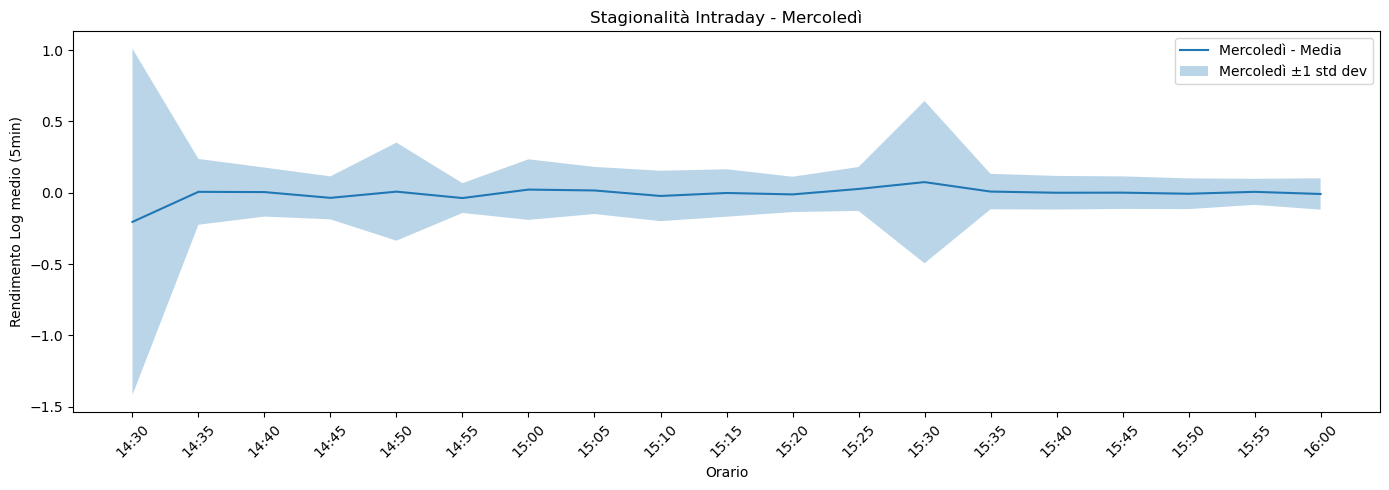

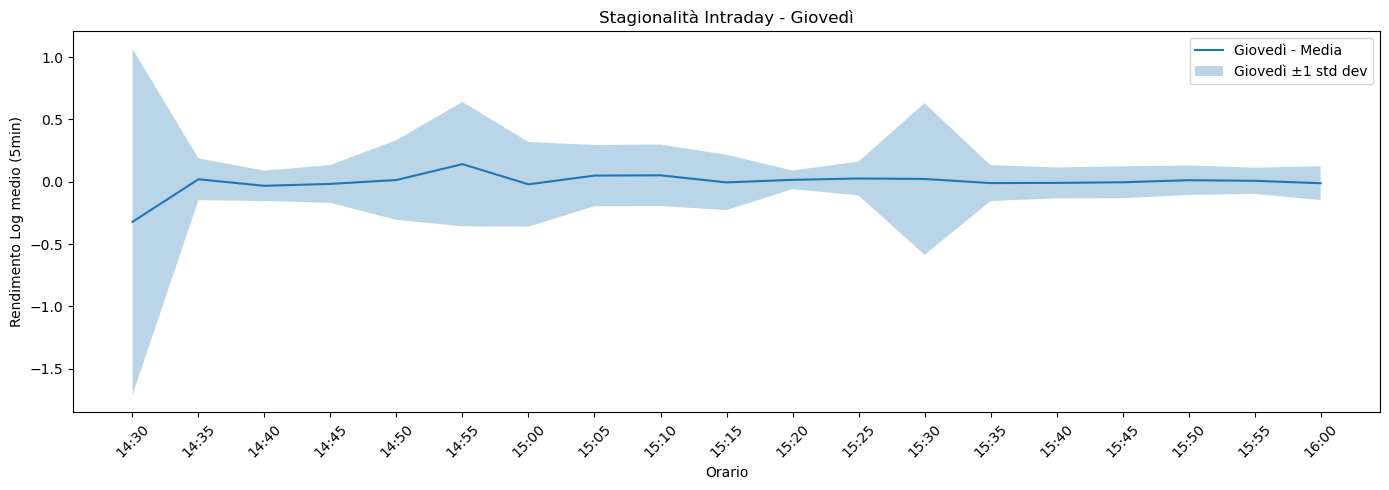

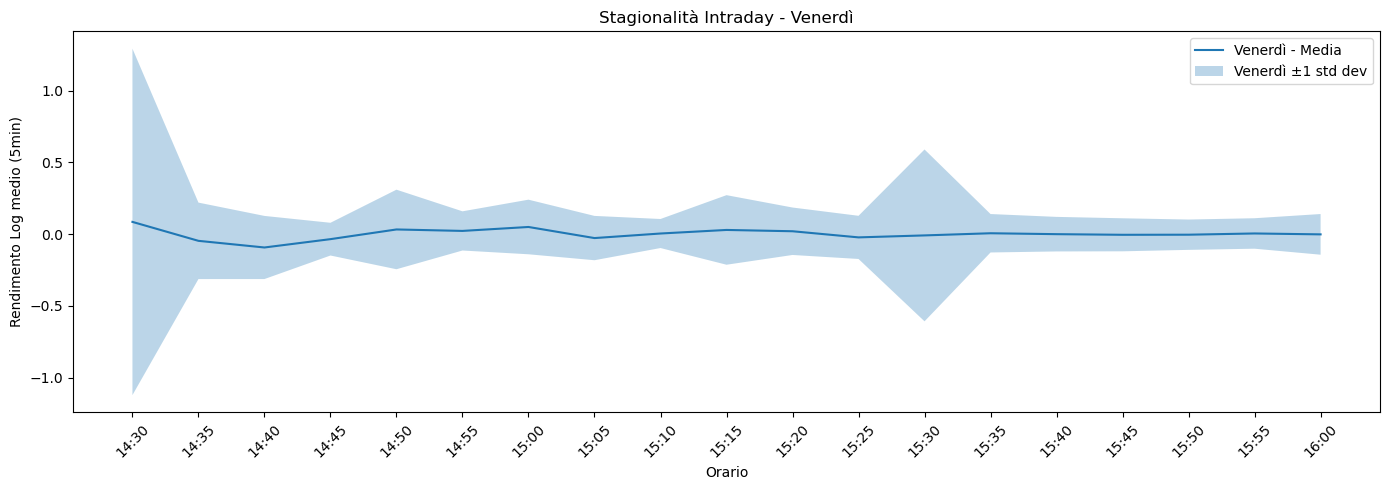

In [9]:
for label, day_data in {
    "Lunedì": filtered[filtered.index.dayofweek == 0],
    "Martedì": filtered[filtered.index.dayofweek == 1],
    "Mercoledì": filtered[filtered.index.dayofweek == 2],
    "Giovedì": filtered[filtered.index.dayofweek == 3],
    "Venerdì": filtered[filtered.index.dayofweek == 4]
}.items():
    
    mean_day = day_data.groupby(day_data.index.time)["close_log_ret_perc"].mean()
    std_day = day_data.groupby(day_data.index.time)["close_log_ret_perc"].std()
    
    # Converti l'indice a stringhe leggibili
    time_labels = [t.strftime('%H:%M') for t in mean_day.index]
    
    plt.figure(figsize=(14, 5))
    plt.plot(time_labels, mean_day.values, label=f'{label} - Media')
    plt.fill_between(time_labels,
                     mean_day.values - std_day.values,
                     mean_day.values + std_day.values,
                     alpha=0.3, label=f'{label} ±1 std dev')
    
    plt.title(f"Stagionalità Intraday - {label}")
    plt.xlabel("Orario")
    plt.ylabel("Rendimento Log medio (5min)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


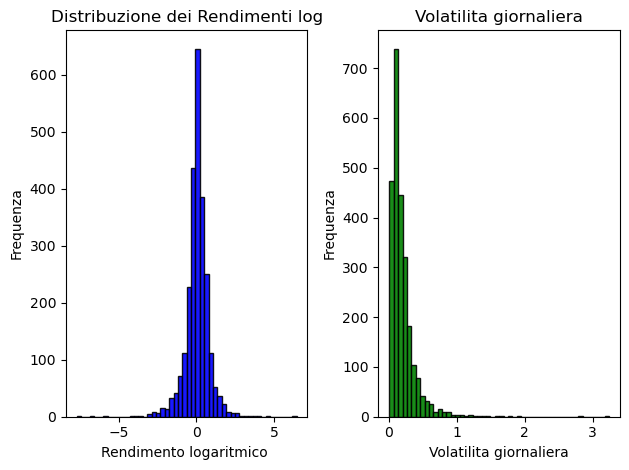

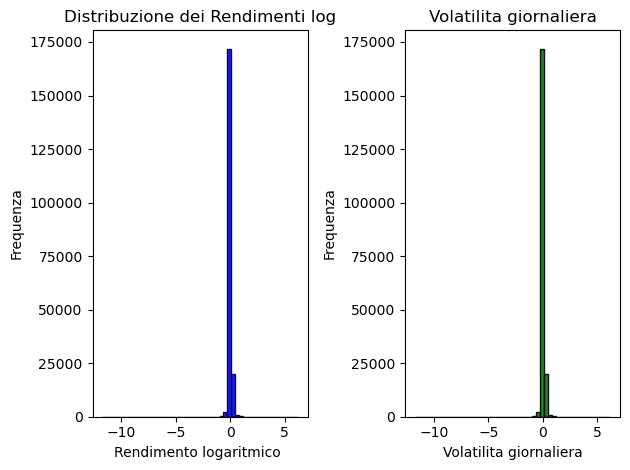

In [9]:

# Istogramma rendimenti semplici
plt.subplot(1, 2, 1)
plt.hist(daily_stats["log_return"], bins=50, alpha=0.9, color='blue', edgecolor='black')
plt.title("Distribuzione dei Rendimenti log")
plt.xlabel("Rendimento logaritmico ")
plt.ylabel("Frequenza")

# Istogramma rendimenti logaritmici
plt.subplot(1, 2, 2)
plt.hist(daily_stats["volatility"], bins=50, alpha=0.9, color='green', edgecolor='black')
plt.title("Volatilita giornaliera")
plt.xlabel("Volatilita giornaliera")
plt.ylabel("Frequenza")

plt.tight_layout()
plt.show()


# Istogramma rendimenti semplici
plt.subplot(1, 2, 1)
plt.hist(returns_log, bins=50, alpha=0.9, color='blue', edgecolor='black')
plt.title("Distribuzione dei Rendimenti log")
plt.xlabel("Rendimento logaritmico ")
plt.ylabel("Frequenza")

# Istogramma rendimenti logaritmici
plt.subplot(1, 2, 2)
plt.hist(returns_log, bins=50, alpha=0.9, color='green', edgecolor='black')
plt.title("Volatilita giornaliera")
plt.xlabel("Volatilita giornaliera")
plt.ylabel("Frequenza")

plt.tight_layout()
plt.show()


In [10]:
#Functions utilitis 

#Plotting 
def plottingSeries(datas,titleNames,x,y,price):
    plt.figure()
    if price=="Close":
        plt.figure()
        datas['Close'].plot(title=titleNames, xlabel='Data', ylabel='Prezzo')
    else:
        datas['Open'].plot(title=titleNames, xlabel='Data', ylabel='Prezzo')
    plt.tight_layout()
    plt.show()    
   



def plotCandlestick(datas, title='Candlestick Chart'):
    
    if not datas.index.inferred_type.startswith('datetime'):
        datas.index = pd.to_datetime(datas.index)


   
    required_cols = ['Open', 'High', 'Low', 'Close']
    if not all(col in datas.columns for col in required_cols):
        raise ValueError(f"Il DataFrame deve contenere le colonne: {required_cols}")

    mpf.plot(
        datas,
        type='candle',
        style='charles',
        title=title,
        ylabel='Prezzo',
        volume=True,  # metti False se non hai 'Volume'
        tight_layout=True,
        show_nontrading=False
    )


    

# Valutazione delle Previsioni di Volatilità

Per valutare l’accuratezza delle previsioni di volatilità ottenute con un modello (come GARCH), si utilizzano diverse metriche. Di seguito sono descritte le principali:

## MAE – Mean Absolute Error

Il MAE misura l’errore medio assoluto tra la volatilità reale e quella prevista:

$$
\text{MAE} = \frac{1}{n} \sum_{t=1}^n \left| \hat{\sigma}_t - \sigma_t \right|
$$

Dove:
- \( \hat{\sigma}_t \): volatilità stimata al tempo \( t \)
- \( \sigma_t \): volatilità reale al tempo \( t \)

Il MAE è semplice da interpretare, ma non penalizza molto gli errori grandi.

## MSE – Mean Squared Error

Il MSE è la media degli errori al quadrato:

$$
\text{MSE} = \frac{1}{n} \sum_{t=1}^n \left( \hat{\sigma}_t - \sigma_t \right)^2
$$

Il MSE penalizza maggiormente gli errori grandi. È spesso usato per confrontare modelli di previsione.

### Perché confrontarlo con un modello Random Walk?

Il modello Random Walk assume che la previsione della volatilità al tempo \( t+1 \) sia uguale al valore osservato al tempo \( t \).  
Questo lo rende una baseline naturale. Se un modello ha un MSE più basso del random walk, allora ha capacità predittiva superiore.

## RMSE – Root Mean Squared Error

L’RMSE è la radice quadrata del MSE:

$$

\text{RMSE} = \sqrt{\text{MSE}}
$$

A differenza del MSE, l’RMSE è espresso nelle stesse unità della variabile target, il che lo rende più interpretabile.

## QLIKE – Quasi Likelihood Loss

La QLIKE è una metrica particolarmente utile per valutare previsioni di volatilità condizionata:

$$
\text{QLIKE} = \frac{1}{n} \sum_{t=1}^n \left( \log \hat{\sigma}_t^2 + \frac{\sigma_t^2}{\hat{\sigma}_t^2} \right)
$$

È derivata dalla funzione di verosimiglianza e premia la coerenza delle previsioni. È più robusta agli outlier rispetto a MSE. Valori più bassi indicano performance migliori.


In [34]:

def mase(y_true, y_pred, seasonality=1):
    n = len(y_true)
    d = np.abs(np.diff(y_true, n=seasonality)).mean()  # MAE naive
    errors = np.abs(y_true - y_pred)
    return errors.mean() / d

def rmsse(y_true, y_pred):
    numerator = np.mean((y_true - y_pred)**2)
    denominator = np.mean(np.diff(y_true)**2)
    return np.sqrt(numerator / denominator)


def computeMetric(predicted_volatility, real_volatility, rendimenti_log):
    # MAE / RMSE
    mae = mean_absolute_error(real_volatility, predicted_volatility)
    mse = mean_squared_error(real_volatility, predicted_volatility)
    rmse = np.sqrt(mse)

    # QLIKE
    qlike = np.mean(np.log(predicted_volatility**2) + (rendimenti_log**2) / (predicted_volatility**2))
    
    print(qlike)

    # MASE e RMSSE
    mase_val = mase(real_volatility, predicted_volatility)
    rmsse_val = rmsse(real_volatility, predicted_volatility)

    # Output
    print(f"MAE   : {mae:.6f}")
    print(f"RMSE  : {rmse:.6f}")
    print(f"QLIKE : {qlike:.6f}")
    print(f"MASE  : {mase_val:.6f}")
    print(f"RMSSE : {rmsse_val:.6f}")


<Figure size 640x480 with 0 Axes>

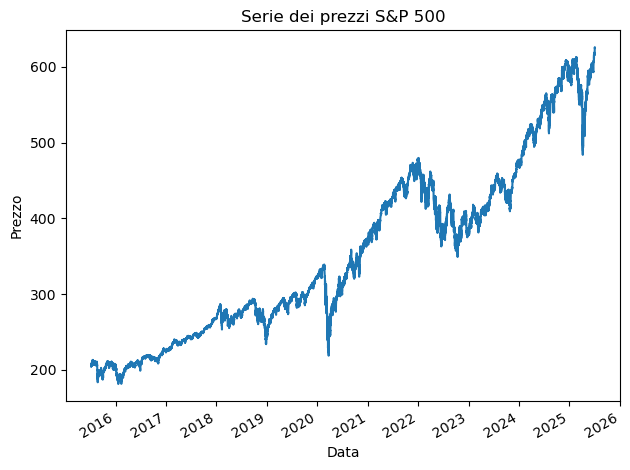

Data                   object
Open                  float64
High                  float64
Low                   float64
Close                 float64
Volume                  int64
Simple_Returns        float64
close_log_ret_perc    float64
dtype: object
                                   Data    Open    High     Low   Close  \
datetime                                                                  
2015-07-07 15:30:00  20150707  15:30:00  206.93  206.99  206.45  206.45   
2015-07-07 15:35:00  20150707  15:35:00  206.46  206.49  206.28  206.40   
2015-07-07 15:40:00  20150707  15:40:00  206.39  206.39  206.13  206.20   
2015-07-07 15:45:00  20150707  15:45:00  206.19  206.36  206.06  206.30   
2015-07-07 15:50:00  20150707  15:50:00  206.30  206.43  206.12  206.34   
...                                 ...     ...     ...     ...     ...   
2025-07-03 18:35:00  20250703  18:35:00  625.92  625.98  625.85  625.96   
2025-07-03 18:40:00  20250703  18:40:00  625.96  626.27  625.94  626.09

In [64]:
plottingSeries(data,"Serie dei prezzi S&P 500","Data",'Prezzo',"Close")

print(data.dtypes)


#plotCandlestick(data)
print(data)

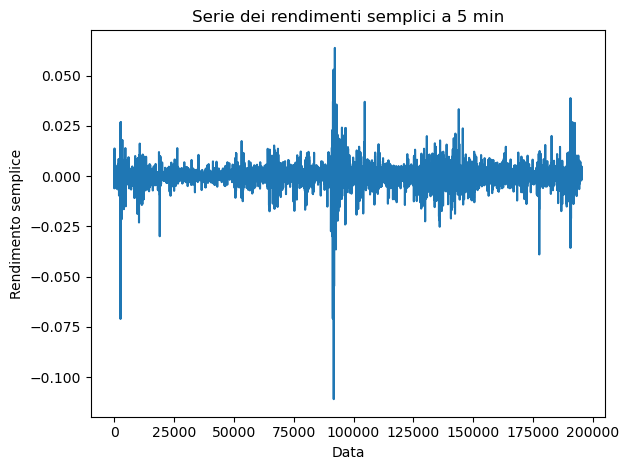

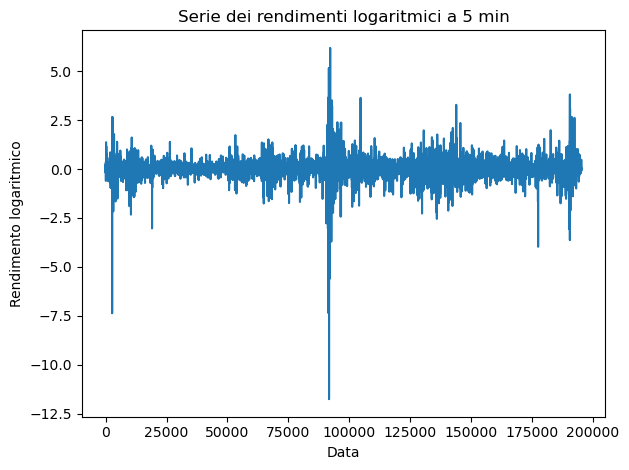

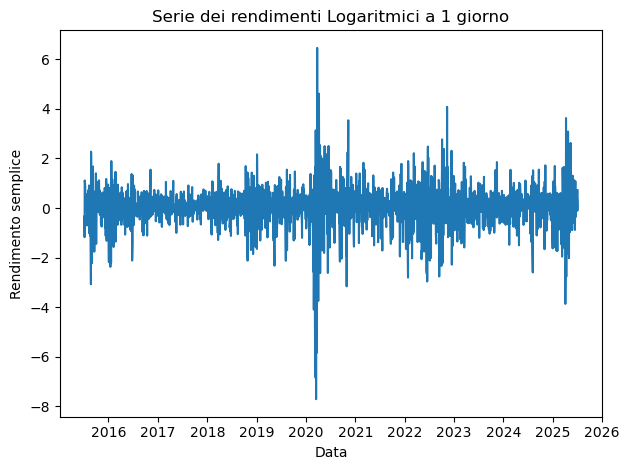

In [17]:
plt.figure()
returns_simple.plot(title='Serie dei rendimenti semplici a 5 min', xlabel='Data', ylabel='Rendimento semplice')
plt.tight_layout()
plt.show()

plt.figure()
returns_log.plot(title='Serie dei rendimenti logaritmici a 5 min', xlabel='Data', ylabel='Rendimento logaritmico')
plt.tight_layout()
plt.show()

plt.figure()
daily_stats["log_return"].plot(title='Serie dei rendimenti Logaritmici a 1 giorno', xlabel='Data', ylabel='Rendimento semplice')
plt.tight_layout()
plt.show()


#La kurtosi dei rendimenti logaritmici è una misura statistica che descrive quanto le code (cioè gli eventi estremi, molto lontani dalla media) della distribuzione dei rendimenti siano più o meno pesanti rispetto a una distribuzione normale (gaussiana).
##  Definizione: Skewness (Asimmetria)

La **skewness** è il **terzo momento centrato standardizzato** della distribuzione e misura l’asimmetria della distribuzione dei dati:

$$
\text{skewness} = \frac{ \mathbb{E}[(X - \mu)^3] }{ \sigma^3 }
$$

Dove:

- \( X \): variabile casuale (in questo caso, i **rendimenti logaritmici**)
- \( \mu \): media dei rendimenti
- \( \sigma \): deviazione standard

---

###  Interpretazione:

- **Skewness > 0** → **Asimmetria positiva**: coda lunga verso destra (eventi estremi positivi più probabili).
- **Skewness < 0** → **Asimmetria negativa**: coda lunga verso sinistra (eventi estremi negativi più probabili).
- **Skewness ≈ 0** → Distribuzione **simmetrica** (come quella normale).

La skewness aiuta a capire se la distribuzione dei rendimenti è **sbilanciata** verso guadagni o perdite estreme.


In [11]:
# 4. Calcola le statistiche descrittive
mean_log   = returns_log.mean()
var_log    = returns_log.var()
max_price  = data['Close'].max()
min_price  = data['Close'].min()
kurt_log   = kurtosis(returns_log, fisher=False)  # Pearson kurtosis
skew_log   = skew(returns_log)
n_obs      = data['Close'].count()

# 5. Stampa tabella formattata con tabulate
table = [
    ['Media rendimenti logaritmici', mean_log],
    ['Varianza rendimenti logaritmici', var_log],
    ['Massimo della serie dei prezzi', max_price.iloc[0] if isinstance(max_price, pd.Series) else max_price],
    ['Minimo della serie dei prezzi', min_price.iloc[0] if isinstance(min_price, pd.Series) else min_price],
    ['Kurtosi rendimenti logaritmici', kurt_log],
    ['Skewness rendimenti logaritmici', skew_log],
    ['Numero osservazioni serie dei prezzi', n_obs.iloc[0] if isinstance(n_obs, pd.Series) else n_obs]
]
print('\nStatistiche descrittive S&P 500 (2015-01-01 – 2025-01-01)\n')
print(tabulate(table, headers=['Statistica', 'Valore'], tablefmt='pretty'))



Statistiche descrittive S&P 500 (2015-01-01 – 2025-01-01)

+--------------------------------------+-----------------------+
|              Statistica              |        Valore         |
+--------------------------------------+-----------------------+
|     Media rendimenti logaritmici     | 0.0005673521127754457 |
|   Varianza rendimenti logaritmici    | 0.016904693322581644  |
|    Massimo della serie dei prezzi    |        626.09         |
|    Minimo della serie dei prezzi     |        181.22         |
|    Kurtosi rendimenti logaritmici    |   635.1850178031053   |
|   Skewness rendimenti logaritmici    |  -5.955689216541937   |
| Numero osservazioni serie dei prezzi |        195336         |
+--------------------------------------+-----------------------+


## Test ADF (Augmented Dickey-Fuller)

Il **test ADF (Augmented Dickey-Fuller)** è un test statistico usato per verificare se una **serie temporale è stazionaria**, ovvero se la sua media e varianza sono costanti nel tempo.

### Ipotesi del Test

- **Ipotesi nulla** $H_0$: la serie ha una _radice unitaria_ $\Rightarrow$ non è stazionaria  
- **Ipotesi alternativa** $H_1$: la serie è stazionaria

### Decisione basata sul p-value

- Se $p$-value $< 0.05$: **rifiutiamo $H_0$** $\Rightarrow$ la serie è stazionaria  
- Se $p$-value $\geq 0.05$: **non possiamo rifiutare $H_0$** $\Rightarrow$ la serie non è stazionaria

### Importanza del test ADF

Molti modelli di previsione per serie temporali (come `ARIMA`, `GARCH`, ecc.) richiedono che i dati siano stazionari.  
Per questo motivo, il test ADF è uno strumento fondamentale in ambito econometrico e finanziario.

È comune applicare il test ADF ai **rendimenti logaritmici** o **rendimenti semplici** di asset finanziari prima di procedere con l’analisi.


In [12]:
print("\nTest ADF - Rendimenti Semplici")
adf_s = adfuller(returns_simple)
print(f"ADF statistic: {adf_s[0]:.4f}")
print(f"p-value: {adf_s[1]:.4f}")
if adf_s[1] < 0.05:
    print("✅ La serie è stazionaria: si rifiuta l'ipotesi nulla di radice unitaria.")
else:
    print("❌ La serie NON è stazionaria: non si può rifiutare l'ipotesi nulla.")

print("\nTest ADF - Rendimenti Logaritmici")
adf_l = adfuller(returns_log)
print(f"ADF statistic: {adf_l[0]:.4f}")
print(f"p-value: {adf_l[1]:.4f}")
if adf_l[1] < 0.05:
    print("✅ La serie è stazionaria: si rifiuta l'ipotesi nulla di radice unitaria.")
else:
    print("❌ La serie NON è stazionaria: non si può rifiutare l'ipotesi nulla.")


Test ADF - Rendimenti Semplici
ADF statistic: -48.9964
p-value: 0.0000
✅ La serie è stazionaria: si rifiuta l'ipotesi nulla di radice unitaria.

Test ADF - Rendimenti Logaritmici
ADF statistic: -48.8579
p-value: 0.0000
✅ La serie è stazionaria: si rifiuta l'ipotesi nulla di radice unitaria.


## Analisi ACF e PACF sui Rendimenti Semplici

L'obiettivo di questo blocco di codice è analizzare la dipendenza temporale nei rendimenti semplici di una serie finanziaria, attraverso i grafici dell'**Autocorrelazione (ACF)** e dell'**Autocorrelazione Parziale (PACF)**.

### Cosa viene fatto

Viene calcolata la dimensione del campione per determinare gli intervalli di confidenza, secondo la formula:

$$
\text{CI}_\alpha = \pm \frac{z_\alpha}{\sqrt{n}}
$$

dove \( n \) è il numero di osservazioni e \( z_\alpha \) è il quantile della distribuzione normale standard.

Successivamente, si tracciano i grafici ACF e PACF per i primi 25 *lag* dei rendimenti semplici. L'**ACF** misura la correlazione tra i rendimenti e i loro valori ritardati, mentre la **PACF** mostra la correlazione condizionata a tutti i lag precedenti.

Nel grafico sono evidenziati gli intervalli di confidenza:
- al 90% con linea verde tratteggiata \( \pm \frac{1.645}{\sqrt{n}} \)
- al 95% con linea blu tratteggiata \( \pm \frac{1.96}{\sqrt{n}} \)
- al 99% con linea rossa tratteggiata \( \pm \frac{2.576}{\sqrt{n}} \)

### Interpretazione

Se una barra del grafico ACF o PACF supera le bande di confidenza, indica che esiste una correlazione statisticamente significativa tra i rendimenti e i loro valori passati a quel lag.

Queste analisi sono utili per determinare se esiste autocorrelazione nella serie e per selezionare il giusto ordine nei modelli ARIMA o GARCH.


In [13]:
# 7. Plot ACF/PACF 5 minuti 
# Calcola dimensione del campione per i CI
n_simple = len(returns_log)
n_log = len(returns_log)

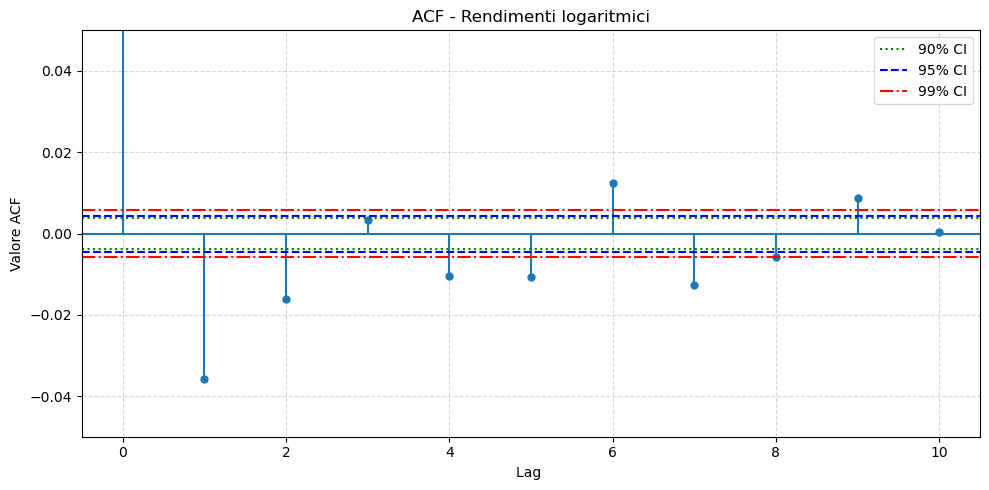

In [14]:

# Calcola dimensione del campione
n_simple = len(returns_log)

# Crea il grafico
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(returns_log, lags=10, ax=ax, alpha=None)

# Titolo e etichette
ax.set_title("ACF - Rendimenti logaritmici")
ax.set_xlabel("Lag ")
ax.set_ylabel("Valore ACF")

# Limiti asse Y per zoom estremo
ax.set_ylim(-0.05, 0.05)

# Bande di confidenza
conf_levels = [(1.645, 'green', ':', '90% CI'),
               (1.96, 'blue', '--', '95% CI'),
               (2.576, 'red', '-.', '99% CI')]

for val, color, style, label in conf_levels:
    bound = val / np.sqrt(n_simple)
    ax.axhline(y=bound, linestyle=style, color=color, label=label)
    ax.axhline(y=-bound, linestyle=style, color=color)

# Migliorie estetiche
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()




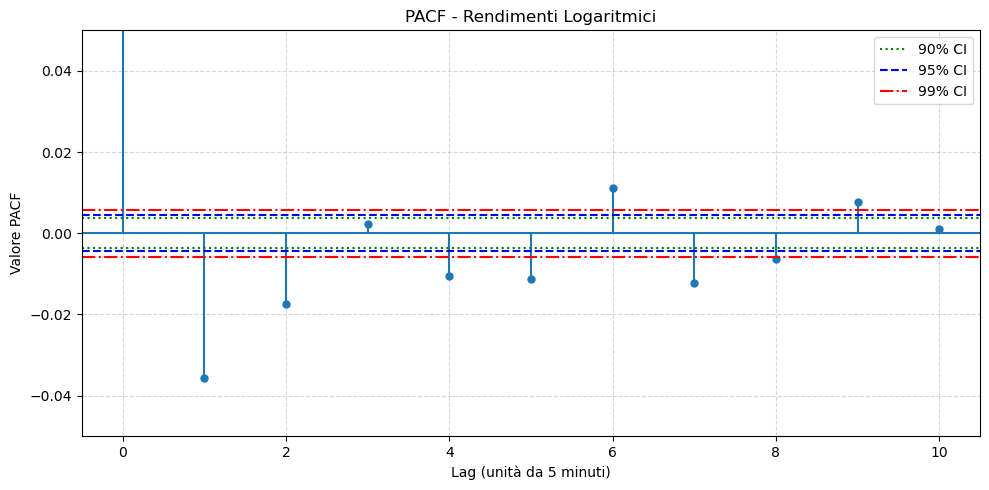

In [16]:


# Calcola dimensione del campione
n_simple = len(returns_simple)

# Crea il grafico PACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(returns_log, lags=10, ax=ax, alpha=None, method='ywm')

# Titolo e etichette
ax.set_title("PACF - Rendimenti Logaritmici")
ax.set_xlabel("Lag (unità da 5 minuti)")
ax.set_ylabel("Valore PACF")

# Limiti asse Y per zoom estremo
ax.set_ylim(-0.05, 0.05)

# Bande di confidenza
conf_levels = [(1.645, 'green', ':', '90% CI'),
               (1.96, 'blue', '--', '95% CI'),
               (2.576, 'red', '-.', '99% CI')]

for val, color, style, label in conf_levels:
    bound = val / np.sqrt(n_simple)
    ax.axhline(y=bound, linestyle=style, color=color, label=label)
    ax.axhline(y=-bound, linestyle=style, color=color)

# Migliorie estetiche
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Test di Eteroschedasticità e Modello GARCH

Il test LM (o ARCH test) viene utilizzato per verificare la presenza di eteroschedasticità condizionata in una serie temporale, ovvero per controllare se la varianza dei rendimenti cambia nel tempo.

## Ipotesi del test:

- $H_0$: non c'è eteroschedasticità (varianza costante)  
- $H_1$: c'è eteroschedasticità (varianza variabile)

## Decisione:

- Se il $p$-value è \textbf{minore di 0.05}, si rifiuta $H_0$ $\Rightarrow$ \textbf{è presente eteroschedasticità} $\Rightarrow$ giustificata la stima di un modello GARCH.  
- Se il $p$-value è \textbf{maggiore o uguale a 0.05}, non si rifiuta $H_0$ $\Rightarrow$ \textbf{nessuna evidenza} di eteroschedasticità.




In [17]:
# 2. Test LM (Lagrange Multiplier) o ARCH Test per eteroschedasticità
lm_test = het_arch(returns_log)
print(f"\nLM Test statistic: {lm_test[0]:.4f}")
print(f"p-value: {lm_test[1]:.4f}")
if lm_test[1] < 0.05:
    print("✅ Presenza di eteroschedasticità: GARCH giustificato")
else:
    print("❌ Nessuna eteroschedasticità: GARCH potrebbe non essere necessario")



LM Test statistic: 774.3887
p-value: 0.0000
✅ Presenza di eteroschedasticità: GARCH giustificato


# Modello GARCH (Generalized Autoregressive Conditional Heteroskedasticity)

Il modello **GARCH** è una generalizzazione del modello **ARCH** introdotto da Engle per descrivere serie temporali con **varianza non costante** (eteroschedasticità condizionata).

Nel contesto dei rendimenti finanziari, la varianza tende a cambiare nel tempo: i periodi di alta volatilità tendono a essere seguiti da altri periodi ad alta volatilità, e lo stesso accade per quelli di bassa volatilità. Questo fenomeno è detto **clustering della volatilità**.

## Specifica del modello GARCH(1,1)

Il modello GARCH(1,1) assume che la **varianza condizionata** al tempo $t$ sia data da:

$$
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$


dove:
- $\sigma_t^2$ è la varianza condizionata del rendimento al tempo $t$
- $\epsilon_{t-1}^2$ è il quadrato dell’errore (innovazione) del tempo $t-1$
- $\sigma_{t-1}^2$ è la varianza condizionata del tempo $t-1$
- $\omega$, $\alpha$, $\beta$ sono i parametri da stimare, con:
  - $\omega > 0$, $\alpha \geq 0$, $\beta \geq 0$
  - $\alpha + \beta < 1$ per garantire la **stazionarietà** del processo

## Interpretazione

- **$\alpha$** misura la reattività della volatilità agli shock recenti (effetto ARCH)
- **$\beta$** misura la persistenza della volatilità (effetto GARCH)
- Se $\alpha + \beta \approx 1$, la volatilità è altamente persistente



# Ipotesi per l'applicazione del modello GARCH

## 1. Stazionarietà dei rendimenti
La serie dei rendimenti deve essere stazionaria, cioè avere media e varianza costanti nel tempo.  
Questa condizione può essere verificata con il test ADF (Augmented Dickey-Fuller).

## 2. Eteroschedasticità condizionata
La varianza condizionata dei rendimenti deve cambiare nel tempo.  
Questo fenomeno è tipico nei mercati finanziari e viene rilevato tramite il test LM (ARCH test).  
Se il $p$-value è inferiore a 0.05, si conferma la presenza di eteroschedasticità.

## 3. Leptocurtosi (code pesanti)
I rendimenti finanziari mostrano code più pesanti rispetto alla distribuzione normale  
(kurtosi maggiore di 3), indicando una maggiore frequenza di eventi estremi.

## 4. Assenza di autocorrelazione nei rendimenti
I rendimenti stessi non devono mostrare autocorrelazione significativa,  
ma i loro quadrati o valori assoluti possono esserlo (tipico segnale di volatilità condizionata).

## 5. Persistenza della volatilità
La volatilità non deve essere casuale, ma presentare dipendenza nel tempo,  
cioè la varianza futura dipende da shock e varianza passati, come modellato nel GARCH.



In [21]:
##SPlitting Dataset 80% training e 20% test set

yD = daily_stats["log_return"].dropna()
y5= returns_log.dropna()

print(yD)
print(y5)

train_sizeD = int(len(yD) * 0.75)
y_trainD, y_testD = yD[:train_sizeD], yD[train_sizeD:]

train_size5 = int(len(y5) * 0.99)
y_train5, y_test5 = y5[:train_size5], y5[train_size5:]

print("Divisione dei rendimenti giornalieri log")
print(y_trainD.size)
print(y_testD.size)

print("Divisione dei rendimenti a 5 min log")
print(y_train5.size)
print(y_test5.size)


2015-07-07   -0.339641
2015-07-08   -1.175204
2015-07-09    1.108799
2015-07-10    1.068023
2015-07-13    0.863853
                ...   
2025-06-27    0.524867
2025-06-30    0.261502
2025-07-01   -0.111731
2025-07-02    0.017810
2025-07-03    0.716354
Name: log_return, Length: 2514, dtype: float64
datetime
2015-07-07 15:35:00   -0.024222
2015-07-07 15:40:00   -0.096946
2015-07-07 15:45:00    0.048485
2015-07-07 15:50:00    0.019387
2015-07-07 15:55:00   -0.184332
                         ...   
2025-07-03 18:35:00    0.006390
2025-07-03 18:40:00    0.020766
2025-07-03 18:45:00   -0.065507
2025-07-03 18:50:00   -0.047959
2025-07-03 18:55:00   -0.006396
Name: close_log_ret_perc, Length: 195335, dtype: float64
Divisione dei rendimenti giornalieri log
1885
629
Divisione dei rendimenti a 5 min log
193381
1954


## QLIKE: Quasi-Likelihood Loss

QLIKE è una metrica comunemente utilizzata per valutare la bontà della previsione della varianza condizionata $\hat{\sigma}_t^2$ fatta da modelli GARCH.  
La formula per il calcolo della QLIKE per ogni istante $t$ è:

$$
\text{QLIKE}(r_t, \hat{\sigma}_t^2) = \log(\hat{\sigma}_t^2) + \frac{r_t^2}{\hat{\sigma}_t^2}
$$

dove:

- $r_t$ è il rendimento logaritmico osservato al tempo $t$ (reale),
- $\hat{\sigma}_t^2$ è la varianza condizionata prevista dal modello.

Un valore più basso della QLIKE indica che la varianza predetta si avvicina maggiormente al comportamento reale dei rendimenti, rendendo il modello più accurato nel descrivere la volatilità del mercato.


## 🔍 Cos’è AIC e BIC

**AIC** = Akaike Information Criterion  
**BIC** = Bayesian Information Criterion

Sono criteri di selezione del modello basati su un compromesso tra:

- **Qualità dell’adattamento ai dati** (quanto bene il modello spiega i dati)
- **Semplicità del modello** (meno parametri = meglio)

---

## 🧠 Formule semplificate

**AIC**  
`AIC = 2k - 2ln(L^)`

**BIC**  
`BIC = ln(n) * k - 2ln(L^)`

Dove:

- `k`: numero di parametri stimati nel modello  
- `L^`: massima verosimiglianza  
- `n`: numero di osservazioni

---

## ✅ Perché più basso è meglio

- Il termine `-2ln(L^)` **premia** il modello se spiega bene i dati.
- Il termine `2k` (in AIC) o `ln(n) * k` (in BIC) **penalizza** i modelli troppo complessi.

👉 Un AIC/BIC più basso indica:

- una buona qualità dell’adattamento,  
- evitando modelli troppo complicati.


In [19]:


def random_search_garch_by_criteria(y, n_iter=20, seed=42):
    np.random.seed(seed)
    random.seed(seed)

    p_values = range(1, 5)
    q_values = range(1, 5)
    distributions = ['normal', 't', 'ged', 'skewt'] #aggiungere sged

    best_aic = float('inf')
    best_bic = float('inf')
    best_loglik = -float('inf')

    best_model_aic = None
    best_model_bic = None
    best_model_loglik = None

    best_info = {'aic': None, 'bic': None, 'loglik': None}

    results = []

    for _ in tqdm(range(n_iter), desc="Random search"):
        p = random.choice(p_values)
        q = random.choice(q_values)
        dist = random.choice(distributions)

        try:
            model = arch_model(y * 100, vol='Garch', p=p, q=q, mean='Zero', dist=dist, rescale=False)
            model_fit = model.fit(disp='off')

            aic = model_fit.aic
            bic = model_fit.bic
            loglik = model_fit.loglikelihood

            results.append((p, q, dist, aic, bic, loglik))

            if aic < best_aic:
                best_aic = aic
                best_model_aic = model_fit
                best_info['aic'] = (p, q, dist)

            if bic < best_bic:
                best_bic = bic
                best_model_bic = model_fit
                best_info['bic'] = (p, q, dist)

            if loglik > best_loglik:
                best_loglik = loglik
                best_model_loglik = model_fit
                best_info['loglik'] = (p, q, dist)

        except Exception as e:
            print(f"❌ Non converge: p={p}, q={q}, dist='{dist}' → {str(e).splitlines()[0]}")
            continue

    print("\n✅ Migliori modelli trovati:")
    if best_info['aic']:
        p, q, dist = best_info['aic']
        print(f"AIC minimo: p={p}, q={q}, dist='{dist}', AIC={best_aic:.2f}")
    if best_info['bic']:
        p, q, dist = best_info['bic']
        print(f"BIC minimo: p={p}, q={q}, dist='{dist}', BIC={best_bic:.2f}")
    if best_info['loglik']:
        p, q, dist = best_info['loglik']
        print(f"Log-likelihood massimo: p={p}, q={q}, dist='{dist}', LogLik={best_loglik:.2f}")

    return {
        'best_aic_model': best_model_aic,
        'best_bic_model': best_model_bic,
        'best_loglik_model': best_model_loglik,
        'all_results': results
    }

returns_log = data['close_log_ret_perc'].dropna()
result = random_search_garch_by_criteria(returns_log)



Random search:  20%|█████▊                       | 4/20 [00:02<00:09,  1.62it/s]/home/luca/anaconda3/envs/nnnnn/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Random search:  30%|████████▋                    | 6/20 [00:03<00:05,  2.42it/s]/home/luca/anaconda3/envs/nnnnn/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Random search:  45%|█████████████                | 9/20 [00:05<00:07,  1.48it/s]/home/luca/anaconda3/envs/nnnnn/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimi


✅ Migliori modelli trovati:
AIC minimo: p=1, q=1, dist='skewt', AIC=1314918.04
BIC minimo: p=1, q=1, dist='skewt', BIC=1314968.95
Log-likelihood massimo: p=4, q=1, dist='skewt', LogLik=-657453.94


In [58]:
#Daily
step = 1
rolling_predictionsD= []
real_valuesD = []

for i in range(0, len(y_testD), step):
    train_data = yD[:train_sizeD + i]  # scala in %
    model = arch_model(train_data, vol='Garch', p=1, q=1,dist="skewt", mean="zero" ,rescale=False)
    model_fitD = model.fit(disp='off')
    forecast = model_fitD.forecast(horizon=1)
    var = forecast.variance.values[-1, 0]
    rolling_predictionsD.append(np.sqrt(var))  # std dev
    real_valuesD.append(y_testD.iloc[i])        # valore reale in quel punto
    
predicted_volatilityD = np.array(rolling_predictionsD)




In [59]:
#5min
step = 1
rolling_predictions5 = []
real_values5 = []

for i in range(0, len(y_test5), step):
    train_data = y5[:train_size5 + i]  # scala in %
    model = arch_model(train_data, vol='Garch', p=1, q=1, dist="skewt",mean='zero',rescale=False)
    model_fit5 = model.fit(disp='off')
    forecast = model_fit5.forecast(horizon=1)
    var = forecast.variance.values[-1, 0]
    rolling_predictions5.append(np.sqrt(var))  # std dev
    real_values5.append(y_test5.iloc[i])        # valore reale in quel punto
    
predicted_volatility5 = np.array(rolling_predictions5)



In [63]:

window = 100
real_volatilityD = (pd.Series(real_valuesD)).rolling(window=window).std().dropna()


predicted_volatility_seriesD = pd.Series(predicted_volatilityD)
forecast_smoothedD = predicted_volatility_seriesD.rolling(window=window).mean().dropna()

min_len = min(len(real_volatilityD), len(forecast_smoothedD))
real_alignedD= real_volatilityD[-min_len:].reset_index(drop=True)
forecast_alignedD = forecast_smoothedD[-min_len:].reset_index(drop=True)


In [61]:
window = 2
real_volatility5 = (pd.Series(real_values5)).rolling(window=window).std().dropna()


predicted_volatility_series5 = pd.Series(predicted_volatility5)
forecast_smoothed5 = predicted_volatility_series5.rolling(window=window).mean().dropna()

min_len = min(len(real_volatility5), len(forecast_smoothed5))
real_aligned5 = real_volatility5[-min_len:].reset_index(drop=True)
forecast_aligned5 = forecast_smoothed5[-min_len:].reset_index(drop=True)

nan
MAE   : 0.054006
RMSE  : 0.063028
QLIKE : nan
MASE  : 11.645147
RMSSE : 6.428398


/tmp/ipykernel_7402/517937949.py:20: RuntimeWarning: '<' not supported between instances of 'datetime.date' and 'int', sort order is undefined for incomparable objects.
  qlike = np.mean(np.log(predicted_volatility**2) + (rendimenti_log**2) / (predicted_volatility**2))


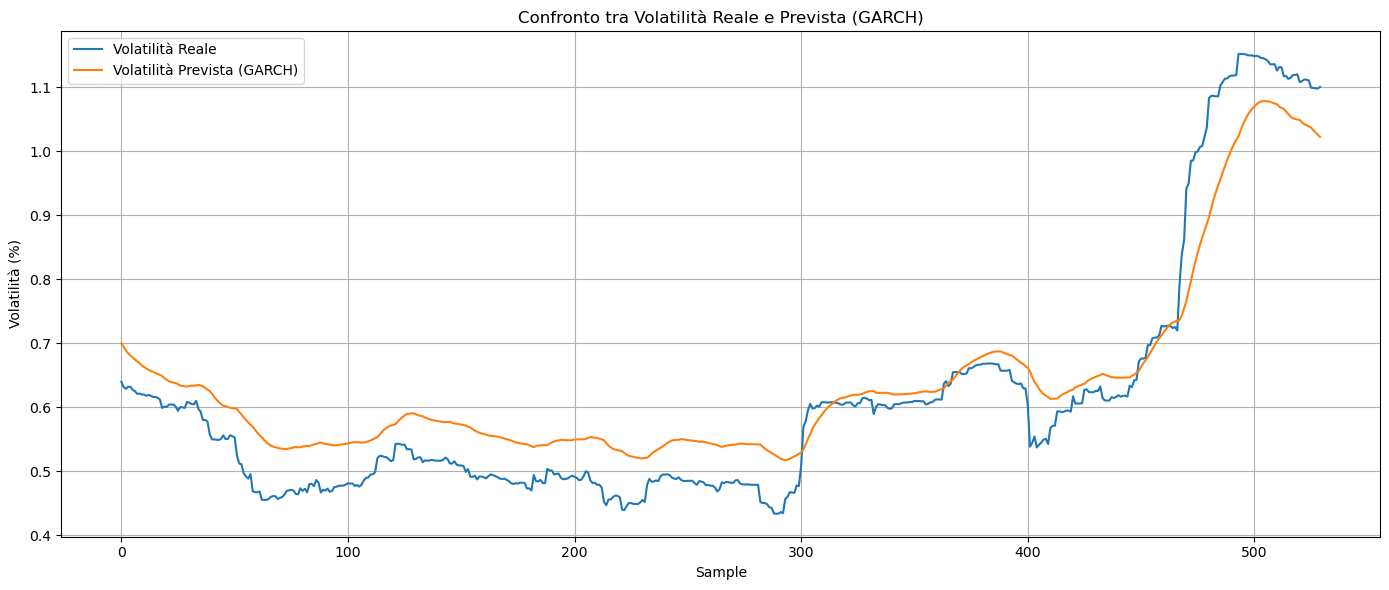

/tmp/ipykernel_7402/517937949.py:20: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  qlike = np.mean(np.log(predicted_volatility**2) + (rendimenti_log**2) / (predicted_volatility**2))


nan
MAE   : 0.043812
RMSE  : 0.062173
QLIKE : nan
MASE  : 1.194792
RMSSE : 1.033221


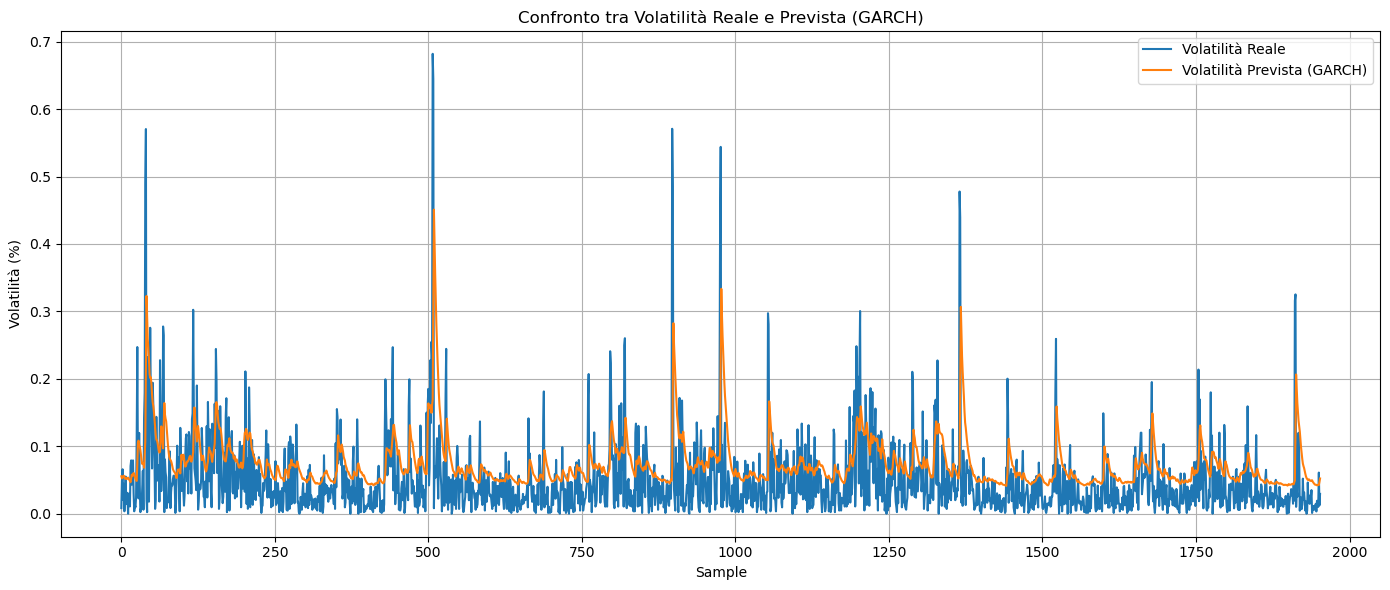

In [64]:
def plottingRealVsPredicted(predicted_volatility, real_volatility):
    df = pd.DataFrame({
        'Volatilità Reale': real_volatility,
        'Volatilità Prevista (GARCH)': predicted_volatility
    })

    plt.figure(figsize=(14, 6))
    df.plot(ax=plt.gca(), linewidth=1.5)
    plt.title("Confronto tra Volatilità Reale e Prevista (GARCH)")
    plt.xlabel("Sample")
    plt.ylabel("Volatilità (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()




computeMetric(forecast_alignedD, real_alignedD,daily_stats["log_return"])
plottingRealVsPredicted(forecast_alignedD, real_alignedD)

computeMetric(forecast_aligned5, real_aligned5,returns_log)
plottingRealVsPredicted(forecast_aligned5, real_aligned5)




In [41]:
print("Daily")
i=400
for i in range(400,410):
    pred = predicted_volatilityD[i]
    real = real_volatilityD.iloc[i]
    print(f"i={i:2d} | Prevista: {pred:.4f} - Reale: {real:.4f} | Errore: {abs(pred - real):.4f}")
print("5 min")
for i in range(400,410):
    pred = predicted_volatility5[i]
    real = real_volatility5.iloc[i]
    print(f"i={i:2d} | Prevista: {pred:.4f} - Reale: {real:.4f} | Errore: {abs(pred - real):.4f}")

Daily
i=400 | Prevista: 0.9674 - Reale: 1.2059 | Errore: 0.2385
i=401 | Prevista: 1.3652 - Reale: 0.6651 | Errore: 0.7001
i=402 | Prevista: 1.4216 - Reale: 0.6586 | Errore: 0.7630
i=403 | Prevista: 1.4224 - Reale: 0.5485 | Errore: 0.8740
i=404 | Prevista: 1.4381 - Reale: 0.3888 | Errore: 1.0493
i=405 | Prevista: 1.3384 - Reale: 0.4394 | Errore: 0.8989
i=406 | Prevista: 1.2061 - Reale: 0.4091 | Errore: 0.7970
i=407 | Prevista: 1.1274 - Reale: 0.4101 | Errore: 0.7172
i=408 | Prevista: 1.0342 - Reale: 0.4158 | Errore: 0.6184
i=409 | Prevista: 1.0137 - Reale: 0.3343 | Errore: 0.6793
5 min
i=400 | Prevista: 0.0465 - Reale: 0.0182 | Errore: 0.0283
i=401 | Prevista: 0.0451 - Reale: 0.0182 | Errore: 0.0268
i=402 | Prevista: 0.0440 - Reale: 0.0177 | Errore: 0.0263
i=403 | Prevista: 0.0434 - Reale: 0.0229 | Errore: 0.0205
i=404 | Prevista: 0.0444 - Reale: 0.0207 | Errore: 0.0237
i=405 | Prevista: 0.0435 - Reale: 0.0212 | Errore: 0.0224
i=406 | Prevista: 0.0433 - Reale: 0.0239 | Errore: 0.0194
i=

In [41]:
#Forcasting e reale annualizzata D
c=252
forecast_annualizedD = forecast_alignedD * np.sqrt(c)
real_annualizedD     = real_alignedD * np.sqrt(c)

#Forcasting e reale annualizzata 5 min

forecast_annualized5 = forecast_aligned5 * np.sqrt(c)
real_annualized5     = real_aligned5 * np.sqrt(c)

In [38]:

plottingRealVsPredicted(forecast_annualizedD, real_annualizedD)


plottingRealVsPredicted(forecast_annualized5, real_annualized5)

NameError: name 'forecast_annualizedD' is not defined

## Formula dei residui nei GARCH

Nel modello GARCH, si assume che il **rendimento logaritmico** $r_t$ si comporti come:

$$
r_t = \sigma_t \cdot \epsilon_t
$$

Dove:

- $r_t$ è il rendimento osservato al tempo $t$,
- $\sigma_t$ è la **deviazione standard condizionata** stimata dal modello (cioè la radice quadrata della varianza prevista),
- $\epsilon_t$ è un **residuo standardizzato**, normalmente distribuito (es. $\epsilon_t \sim \mathcal{N}(0, 1)$).

---

###  Residuo standardizzato

$$
\epsilon_t = \frac{r_t}{\sigma_t}
$$

Questa è **la formula chiave**: il residuo standardizzato misura quanto il rendimento $r_t$ si discosta dalla previsione del modello in termini di deviazione standard.


In [65]:
residuals5 = model_fit5.resid.dropna()
std_residuals5 = model_fit5.std_resid.dropna()

residualsD = model_fit5.resid.dropna()
std_residualsD = model_fit5.std_resid.dropna()


#residui_standardizzatiD = np.array(y_testD) * 100 / predicted_volatilityD

#residui_standardizzati5 = np.array(y_test5) * 100 / predicted_volatility5


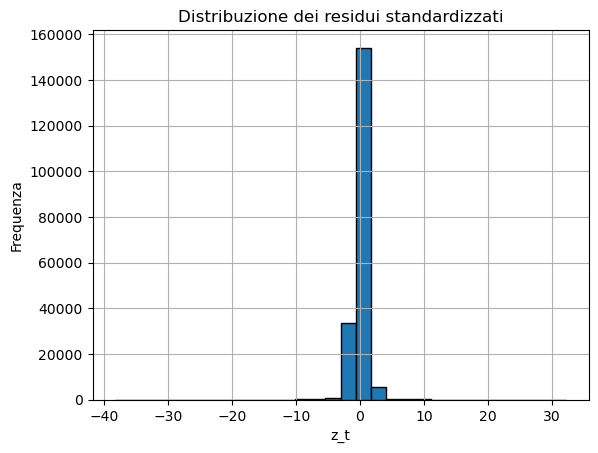

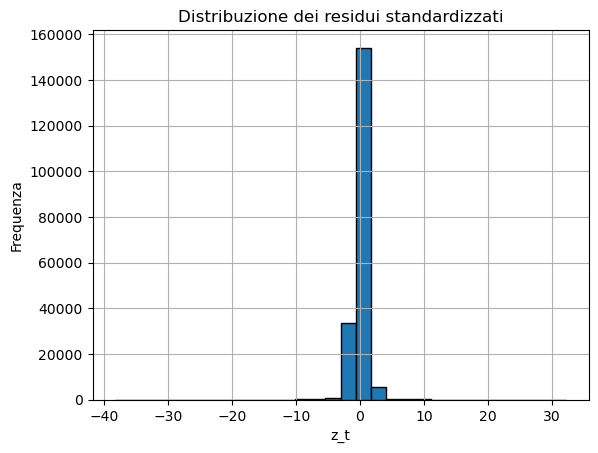

In [66]:

plt.hist(std_residuals5, bins=30, edgecolor='black')
plt.title("Distribuzione dei residui standardizzati")
plt.xlabel("z_t")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()

plt.hist(std_residualsD, bins=30, edgecolor='black')
plt.title("Distribuzione dei residui standardizzati")
plt.xlabel("z_t")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()



## Shapiro wilk test 
serve per verificare se una determinata serie di dati può essere considerata estratta da una distribuzione normale.
Esempi pratici:

    Capire se i residui di un modello GARCH o regressione sono normali.

    Capire se una variabile può essere modellata con metodi parametrici (che richiedono normalità).

Il test di Shapiro-Wilk verifica se un campione di dati proviene da una distribuzione normale. La statistica del test è data da:

$$
W = \frac{\left( \sum_{i=1}^{n} a_i x_{(i)} \right)^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2}
$$


Il valore di \( W \) misura la deviazione dei dati dalla normalità:
- Valori **vicini a 1** indicano **normalità**.
- Valori **più bassi** indicano **scostamenti** dalla normalità.

Il test produce anche un **p-value**:
- Se \( p > \alpha \) (es. \( 0.05 \)), **non si rifiuta l'ipotesi nulla** → i dati **sono compatibili con una distribuzione normale**.
- Se \( p \le \alpha \), **si rifiuta l'ipotesi nulla** → i dati **non sono normali**.


In [69]:
from scipy.stats import shapiro

stat, p = shapiro(returns_log)
if p < 0.05:
    print("❌ I dati NON sono normali (Shapiro-Wilk)")
else:
    print("✅ I dati sono normali (Shapiro-Wilk)")


❌ I dati NON sono normali (Shapiro-Wilk)


/home/luca/anaconda3/envs/nnnnn/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 195335.
  res = hypotest_fun_out(*samples, **kwds)


## D'Agostino and Pearson Test

⚙️ Come funziona

Il test combina due componenti:

    Skewness (asimmetria): misura quanto la distribuzione è inclinata rispetto a una normale.

    Kurtosis (curtosi): misura quanto è “schiacciata” o “a punta” rispetto a una normale.

In [71]:
from scipy.stats import normaltest

stat, p = normaltest(returns_log)
if p < 0.05:
    print("❌ I dati NON sono normali (D'Agostino-Pearson)")
else:
    print("✅ I dati sono normali (D'Agostino-Pearson)")


❌ I dati NON sono normali (D'Agostino-Pearson)


## Kolmogorov–Smirnov Test (K–S)

Obiettivo: confronta la distribuzione empirica dei dati con una distribuzione teorica (es. normale).

In [ ]:
from scipy.stats import kstest, norm

data_std = (data - data.mean()) / data.std()
stat, p = kstest(data_std, 'norm')
if p < 0.05:
    print("❌ I dati NON sono normali (K–S)")
else:
    print("✅ I dati sono normali (K–S)")


## Anderson-Darling Test

In [ ]:
from scipy.stats import anderson

result = anderson(data, dist='norm')
print("Statistic:", result.statistic)
for i in range(len(result.critical_values)):
    sig_level = result.significance_level[i]
    crit = result.critical_values[i]
    if result.statistic > crit:
        print(f"❌ Non normale al livello {sig_level}%")
    else:
        print(f"✅ Normale al livello {sig_level}%")


In [ ]:
# 11. Test di Jarque-Bera sui residui standardizzati (normalità)
jb_stat, jb_pvalue = jarque_bera(std_residuals5)
print("\n📊 Test di Jarque-Bera sui residui standardizzati (normalità):")
print(f"Statistiche JB: {jb_stat:.4f}")
print(f"p-value: {jb_pvalue:.4f}")
if jb_pvalue < 0.05:
    print("❌ I residui NON seguono una distribuzione normale (normalità rifiutata)")
else:
    print("✅ I residui seguono una distribuzione normale (non si rifiuta la normalità)")

    # 11. Test di Jarque-Bera sui residui standardizzati (normalità)
jb_stat, jb_pvalue = jarque_bera(std_residualsD)
print("\n📊 Test di Jarque-Bera sui residui standardizzati (normalità):")
print(f"Statistiche JB: {jb_stat:.4f}")
print(f"p-value: {jb_pvalue:.4f}")
if jb_pvalue < 0.05:
    print("❌ I residui NON seguono una distribuzione normale (normalità rifiutata)")
else:
    print("✅ I residui seguono una distribuzione normale (non si rifiuta la normalità)")


#Test di normali 
#siapiro wilks, Dagostino Pearson

#Test di golmogorf smirnov= 
#Test Underson dagly


📊 Test di Jarque-Bera sui residui standardizzati (normalità):
Statistiche JB: 131.1482
p-value: 0.0000
❌ I residui NON seguono una distribuzione normale (normalità rifiutata)


<Figure size 650x450 with 0 Axes>

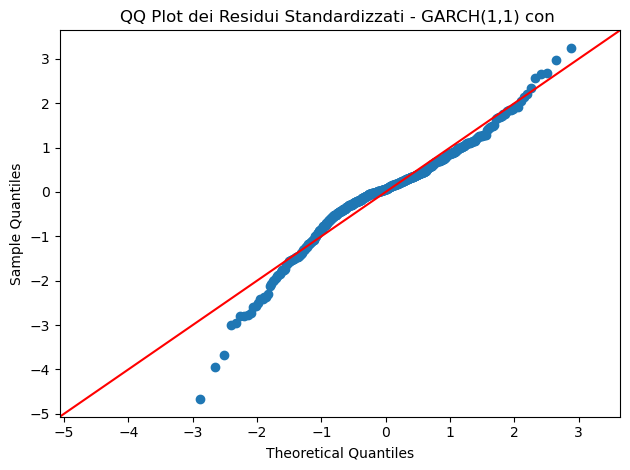

In [ ]:
# 18. QQ Plot dei residui
plt.figure(figsize=(6.5, 4.5))
qqplot(std_residuals5, line='45', fit=True)
plt.title("QQ Plot dei Residui Standardizzati - GARCH(1,1) con ")
plt.tight_layout()
plt.show()

# 18. QQ Plot dei residui
plt.figure(figsize=(6.5, 4.5))
qqplot(std_residualsD, line='45', fit=True)
plt.title("QQ Plot dei Residui Standardizzati - GARCH(1,1) con ")
plt.tight_layout()
plt.show()

In [ ]:
# Test Ljung-Box sui residui
lb_test_resid = acorr_ljungbox(std_res, lags=[10], return_df=True)

# Test Ljung-Box sui residui al quadrato
lb_test_squared = acorr_ljungbox(std_res ** 2, lags=[10], return_df=True)

In [14]:

# Calcola dimensione del campione
n_simple = len(std_residualsD)

# Crea il grafico
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(std_residualsD, lags=10, ax=ax, alpha=None)

# Titolo e etichette
ax.set_title("ACF - Residui standardizzati a 5 min (Zoom Y: -0.05 / 0.05)")
ax.set_xlabel("Lag ")
ax.set_ylabel("Valore ACF")

# Limiti asse Y per zoom estremo
ax.set_ylim(-0.05, 0.05)

# Bande di confidenza
conf_levels = [(1.645, 'green', ':', '90% CI'),
               (1.96, 'blue', '--', '95% CI'),
               (2.576, 'red', '-.', '99% CI')]

for val, color, style, label in conf_levels:
    bound = val / np.sqrt(n_simple)
    ax.axhline(y=bound, linestyle=style, color=color, label=label)
    ax.axhline(y=-bound, linestyle=style, color=color)

# Migliorie estetiche
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()



NameError: name 'std_residualsD' is not defined

In [ ]:
# Calcola dimensione del campione
n_simple = len(std_residuals5)

# Crea il grafico
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(std_residuals5, lags=10, ax=ax, alpha=None)

# Titolo e etichette
ax.set_title("ACF - Rendimenti Semplici (Zoom Y: -0.05 / 0.05)")
ax.set_xlabel("Lag ")
ax.set_ylabel("Valore ACF")

# Limiti asse Y per zoom estremo
ax.set_ylim(-0.05, 0.05)

# Bande di confidenza
conf_levels = [(1.645, 'green', ':', '90% CI'),
               (1.96, 'blue', '--', '95% CI'),
               (2.576, 'red', '-.', '99% CI')]

for val, color, style, label in conf_levels:
    bound = val / np.sqrt(n_simple)
    ax.axhline(y=bound, linestyle=style, color=color, label=label)
    ax.axhline(y=-bound, linestyle=style, color=color)

# Migliorie estetiche
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 🔍 Cos’è AIC e BIC

**AIC** = Akaike Information Criterion  
**BIC** = Bayesian Information Criterion

Sono criteri di selezione del modello basati su un compromesso tra:

- **Qualità dell’adattamento ai dati** (quanto bene il modello spiega i dati)
- **Semplicità del modello** (meno parametri = meglio)

---

## 🧠 Formule semplificate

**AIC**  
`AIC = 2k - 2ln(L^)`

**BIC**  
`BIC = ln(n) * k - 2ln(L^)`

Dove:

- `k`: numero di parametri stimati nel modello  
- `L^`: massima verosimiglianza  
- `n`: numero di osservazioni

---

## ✅ Perché più basso è meglio

- Il termine `-2ln(L^)` **premia** il modello se spiega bene i dati.
- Il termine `2k` (in AIC) o `ln(n) * k` (in BIC) **penalizza** i modelli troppo complessi.

👉 Un AIC/BIC più basso indica:

- una buona qualità dell’adattamento,  
- evitando modelli troppo complicati.


## RNN

##  Long Short-Term Memory (LSTM)

Le **LSTM** (Long Short-Term Memory) sono una variante delle Reti Neurali Ricorrenti (RNN), progettate per superare i limiti delle RNN classiche, come la difficoltà nel catturare dipendenze a lungo termine dovuta al problema del vanishing gradient.

Una LSTM è composta da **celle di memoria** che, tramite meccanismi di **gate (porte)**, controllano quali informazioni conservare, dimenticare o aggiornare nel tempo.

---

###  Formulazione Matematica

Sia \( x_t \) l'input al tempo \( t \), \( h_t \) lo stato nascosto, e \( C_t \) lo stato della cella. I parametri del modello sono:

- \( W_f, W_i, W_C, W_o \): pesi associati agli input,
- \( U_f, U_i, U_C, U_o \): pesi associati allo stato precedente,
- \( b_f, b_i, b_C, b_o \): bias dei rispettivi gate.

#### 1. Forget gate (porta di dimenticanza)
Decide cosa dimenticare dalla cella:
$$
f_t = \sigma(W_f x_t + U_f h_{t-1} + b_f)
$$

#### 2. Input gate (porta di aggiornamento)
Determina quali nuove informazioni memorizzare:
$$
i_t = \sigma(W_i x_t + U_i h_{t-1} + b_i)
$$

#### 3. Candidata alla cella
Genera un candidato per aggiornare la memoria:
$$
\tilde{C}_t = \tanh(W_C x_t + U_C h_{t-1} + b_C)
$$

#### 4. Stato della cella aggiornato
Combina il vecchio stato con quello nuovo:
$$
C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t
$$

#### 5. Output gate
Decide cosa emettere come output:
$$
o_t = \sigma(W_o x_t + U_o h_{t-1} + b_o)
$$

#### 6. Stato nascosto aggiornato
È il vero output della LSTM:
$$
h_t = o_t \odot \tanh(C_t)
$$

htht​ rappresenta l’informazione elaborata fino a tt, ma non è una memoria esplicita di tutti i hihi​ per i≤ti≤t.
È uno stato ricorsivo aggiornato, che porta memoria "condensata" del passato.

---

###  Significato dei simboli

- \( \sigma \): funzione sigmoide \( \sigma(x) = \frac{1}{1 + e^{-x}} \)
- \( \tanh \): funzione tangente iperbolica
- \( \odot \): prodotto elemento per elemento (Hadamard)
- \( h_{t-1} \): stato nascosto precedente
- \( C_{t-1} \): memoria precedente
- \( x_t \): input corrente

---

###  Obiettivo nella previsione della volatilità

La LSTM viene **addestrata a prevedere la deviazione standard dei rendimenti logaritmici futuri**, ossia la **volatilità stimata** al tempo \( t+1 \), sulla base di una finestra passata di osservazioni \([r_{t-59}, \dots, r_t]\).

L’output finale sarà:
$$
\hat{\sigma}_{t+1} = \text{LSTM}(r_{t-59}, \dots, r_t)
$$

Questa architettura è in grado di apprendere pattern complessi nel tempo, anche non lineari, rendendola ideale per dati finanziari ad alta frequenza.


## Attenzione! LSTM se vogliamo stimare la std al tempo t+1 in input dobbiamo dargli std

In [72]:
#aggiugere piu varibili al dataset 
data["std_21d"] = data["close_log_ret_perc"].rolling(window=1638).std().dropna()
data["mean_60d"] = data["close_log_ret_perc"].rolling(window=4680).mean().dropna()
data["mean_60d"] = data["close_log_ret_perc"].rolling(window=4680).mean()
data["mean_21d"] = data["close_log_ret_perc"].rolling(window=1638).mean()

print(data)
print(data.columns)

                                   Data    Open    High     Low   Close  \
datetime                                                                  
2015-07-07 15:30:00  20150707  15:30:00  206.93  206.99  206.45  206.45   
2015-07-07 15:35:00  20150707  15:35:00  206.46  206.49  206.28  206.40   
2015-07-07 15:40:00  20150707  15:40:00  206.39  206.39  206.13  206.20   
2015-07-07 15:45:00  20150707  15:45:00  206.19  206.36  206.06  206.30   
2015-07-07 15:50:00  20150707  15:50:00  206.30  206.43  206.12  206.34   
...                                 ...     ...     ...     ...     ...   
2025-07-03 18:35:00  20250703  18:35:00  625.92  625.98  625.85  625.96   
2025-07-03 18:40:00  20250703  18:40:00  625.96  626.27  625.94  626.09   
2025-07-03 18:45:00  20250703  18:45:00  626.10  626.10  625.66  625.68   
2025-07-03 18:50:00  20250703  18:50:00  625.67  625.88  624.88  625.38   
2025-07-03 18:55:00  20250703  18:55:00  625.38  625.75  625.23  625.34   

                     Vol

In [73]:

# 3. Calcolo rolling std locale su un giorno 
returns_log = data["close_log_ret_perc"]
y = returns_log.dropna()
rolling_std = y.rolling(window=78*5).std()

# 4. Crea nuovo DataFrame combinato e allinea tutte le colonne con lo stesso indice
combined = pd.concat([
    y.rename("rendimenti_log_%"),
    rolling_std.rename("std_giornaliera"),
    data["std_21d"],
    data["mean_21d"],
    data["mean_60d"]
], axis=1).dropna()

print(combined.head())
print(combined.columns)


                     rendimenti_log_%  std_giornaliera   std_21d  mean_21d  \
datetime                                                                     
2015-09-30 15:30:00          1.388948         0.145064  0.152828 -0.002383   
2015-09-30 15:35:00          0.225267         0.145367  0.152863 -0.002132   
2015-09-30 15:40:00         -0.193804         0.145628  0.152937 -0.002247   
2015-09-30 15:45:00          0.078614         0.145412  0.152919 -0.002122   
2015-09-30 15:50:00          0.000000         0.145385  0.152844 -0.002239   

                     mean_60d  
datetime                       
2015-09-30 15:30:00 -0.001699  
2015-09-30 15:35:00 -0.001646  
2015-09-30 15:40:00 -0.001666  
2015-09-30 15:45:00 -0.001660  
2015-09-30 15:50:00 -0.001664  
Index(['rendimenti_log_%', 'std_giornaliera', 'std_21d', 'mean_21d',
       'mean_60d'],
      dtype='object')


In [74]:
# 1. Definisci X (tutte le feature) e y (std_giornaliera futura)
X = combined.drop(columns=["std_giornaliera"])  # tutte le feature fino a t
y = combined["std_giornaliera"].shift(-1)       # target al tempo t+1

# 2. Rimuovi righe con NaN (l'ultima riga sarà NaN dopo lo shift)
X = X[:-1]
y = y[:-1]

In [75]:

scaler_X = StandardScaler()
scaler_y = StandardScaler()


X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# 4. Dividi in train/test
split_idx = int(len(X_scaled) * 0.99)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# 5. Crea sequenze per LSTM
def create_lstm_dataset(X, y, window_size):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - window_size):
        X_lstm.append(X[i:i+window_size])
        y_lstm.append(y[i+window_size])
    return np.array(X_lstm), np.array(y_lstm)

window_size = 78 * 5  # 1 giorno
X_lstm_train, y_lstm_train = create_lstm_dataset(X_train, y_train, window_size)
X_lstm_test, y_lstm_test = create_lstm_dataset(X_test, y_test, window_size)

In [76]:

# 4. Reshape per LSTM (aggiungo dimensione "features" se manca)
X_lstm_train = X_lstm_train.reshape((X_lstm_train.shape[0], X_lstm_train.shape[1], X_lstm_train.shape[2]))
X_lstm_test = X_lstm_test.reshape((X_lstm_test.shape[0], X_lstm_test.shape[1], X_lstm_test.shape[2]))


In [77]:

# 5. Costruzione del modello LSTM
LSTM = tf.keras.models.Sequential()
LSTM.add(tf.keras.layers.LSTM(units=50, return_sequences=False, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])))
LSTM.add(tf.keras.layers.LayerNormalization())
LSTM.add(tf.keras.layers.Dense(units=1))

LSTM.compile(optimizer='adam', loss='mse')

# 6. Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 7. Addestramento
history = LSTM.fit(
    X_lstm_train,
    y_lstm_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


I0000 00:00:1752680315.983875    7402 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752680316.158654    7402 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752680316.160423    7402 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752680316.164097    7402 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/20


2025-07-16 17:38:38.743316: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


5298/5298 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.1718 - val_loss: 0.3108
Epoch 2/20
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: 0.0782 - val_loss: 0.1272
Epoch 3/20
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: 0.0223 - val_loss: 0.0549
Epoch 4/20
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: 0.0130 - val_loss: 0.0401
Epoch 5/20
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 0.0040 - val_loss: 0.0255
Epoch 6/20
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 0.0029 - val_loss: 0.0234
Epoch 7/20
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 0.0024 - val_loss: 0.0207
Epoch 8/20
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 0.0020 - val_loss: 0.0239
Epoch 9/20
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: 0.0019 - val_loss: 0.0253
Epoch 10/20
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 0.0016 - val_loss: 0.0217
Epoch 11/20
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 0.0014 - val_loss: 0.0184
Epoch 12/20
5298/5298 ━━━━━━━━

In [15]:
#cross validation

#cross validation con hypertuning

#fase di test



def compute_volatility_metrics(predicted_volatility, real_volatility):
    """
    Calcola le metriche di errore tra la volatilità prevista e quella reale.

    Parametri:
    - predicted_volatility: array-like, valori di deviazione standard previsti (es: dalla LSTM)
    - real_volatility: array-like, valori reali di deviazione standard (rolling std)
    - log_returns: array-like (opzionale), log-return reali per QLIKE (non richiesto se si salta QLIKE)

    Output:
    - Dizionario con MAE, MSE, RMSE e (facoltativamente) QLIKE
    """
    mae = mean_absolute_error(real_volatility, predicted_volatility)
    mse = mean_squared_error(real_volatility, predicted_volatility)
    rmse = np.sqrt(mse)

    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    }

    return metrics


In [78]:
# Predizione
y_pred_scaled = LSTM.predict(X_lstm_test)



# Inverti la normalizzazione per ottenere la std reale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_lstm_test.reshape(-1, 1)).flatten()


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [81]:

computeMetric(y_pred,y_true,returns_log)

ValueError: operands could not be broadcast together with shapes (195336,) (1517,) 

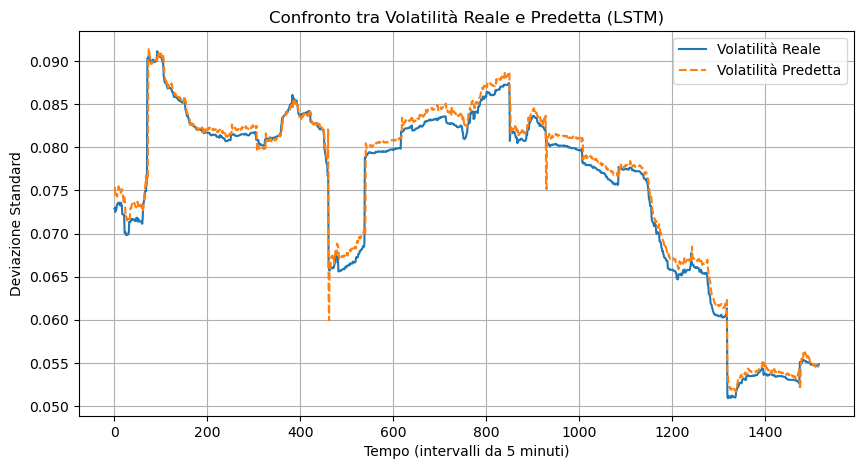

In [82]:


plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Volatilità Reale')
plt.plot(y_pred, label='Volatilità Predetta', linestyle='--')
plt.title("Confronto tra Volatilità Reale e Predetta (LSTM)")
plt.xlabel("Tempo (intervalli da 5 minuti)")
plt.ylabel("Deviazione Standard")
plt.legend()
plt.grid(True)
plt.show()


## Strategia di Trading 

In [19]:
# Supponiamo che y_pred sia un array/serie di N valori previsti
# e che corrisponda agli ultimi N valori del dataset
N = len(y_pred)

# Tagliamo le ultime N righe del DataFrame per allineare
data_cut = data.iloc[-N:].copy()

# Aggiungiamo la previsione come nuova colonna
data_cut["y_pred"] = y_pred


In [20]:
import backtrader as bt
import pandas as pd

%matplotlib inline


# 1. Carica il tuo DataFrame e converte la colonna data
data = pd.read_csv("/home/luca/Mercati/dati_storici_SP500TM5⁄10years.csv", sep=',')

print(data.columns)
# Assumiamo che la colonna si chiami 'Date' o simile: controlla il nome preciso
data['Data'] = pd.to_datetime(data['Data'])  # converte in datetime
data.set_index('Data', inplace=True)         # imposta come indice

class VolatilityStrategy(bt.Strategy):
    params = (('threshold', 0.02),)

    def next(self):
        current_time = self.data.datetime.time(0)
        vol = self.data.vol_pred[0]  # volatilità stimata

        # Se non hai già una posizione e sei all'inizio della giornata
        if not self.position and current_time == bt.time(9, 30):
            if vol > self.params.threshold:
                self.buy()
            else:
                self.sell()

        # Chiudi la posizione alla fine della giornata
        elif self.position and current_time == bt.time(15, 55):
            self.close()

# 3. Inizializza Cerebro
cerebro = bt.Cerebro()

# 4. Carica i dati in formato PandasData
datafeed = bt.feeds.PandasData(dataname=data)

# 5. Aggiungi dati e strategia
cerebro.adddata(datafeed)
cerebro.addstrategy(MyStrategy)


# 6. Esegui e mostra
cerebro.run()
cerebro.plot(iplot=True)

figs = cerebro.plot(iplot=False)
fig = figs[0][0]
fig.savefig("backtest_plot.png", dpi=300)




Index(['Data', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


NameError: name 'MyStrategy' is not defined